## 1. Pre-processing (for NCBI):
#### Import refseq IDs, download each assembly's report and find the alternative loci chromosome region ids

In [2]:
# IMPORT REFSEQ IDS
import pandas as pd

# Replace 'your_file.csv' with the actual path to your CSV
df = pd.read_csv('NCBI/mappingids.csv')
# Extract the 'Refseq_id' column as a list
refseq_ids = df['Refseq_id'].tolist()

# Create a dictionary mapping REFSEQ ids to species names
refseq_to_species = dict(zip(df['Refseq_id'], df['Name']))
print(refseq_ids[:5])  # Show the first 5 IDs


['GCF_000001405.38', 'GCF_000001635.26', 'GCF_000002035.6', 'GCF_000002315.6', 'GCF_000224145.1']


In [3]:
import requests
from bs4 import BeautifulSoup
from io import StringIO

def fetch_alt_loci_from_ncbi_assembly(assembly_accession):
    """
    Given an NCBI assembly accession (e.g., GCF_000001405.40), return a list of alternative loci sequence names.
    """
    # Format accession path for FTP structure
    assembly_root=assembly_accession.split(".")[0]
    parts = assembly_root.split("_")
    prefix = parts[0]
    numbers = parts[1]
    path_parts = [numbers[i:i+3] for i in range(0, len(numbers), 3)]
    base_folder_url = f"https://ftp.ncbi.nlm.nih.gov/genomes/all/{'/'.join([prefix] + path_parts)}"
    
    # Look for the specific subfolder matching the accession (with potential suffix)
    response = requests.get(base_folder_url)
    if not response.ok:
        raise FileNotFoundError(f"Could not access base path {base_folder_url} on NCBI FTP.")

    soup = BeautifulSoup(response.text, "html.parser")
    folder_name = None
    for link in soup.find_all("a"):
        href = link.get("href")
        if href and href.startswith(assembly_accession):
            folder_name = href.strip("/")
            break

    if not folder_name:
        raise FileNotFoundError(f"Assembly folder starting with {assembly_accession} not found on NCBI FTP.")

    # Now download the assembly report from that folder
    full_path = f"{base_folder_url}/{folder_name}"
    report_url = f"{full_path}/{folder_name}_assembly_report.txt"
    report_response = requests.get(report_url)
    if not report_response.ok:
        raise FileNotFoundError(f"Could not find assembly report at {report_url}")

    # Parse the report
    alt_loci = []
    for line in StringIO(report_response.text):
        if line.startswith("#"):
            continue
        fields = line.strip().split("\t")
        if len(fields) >= 5 and fields[7] != "Primary Assembly":
            alt_loci.append(fields[4])  # Sequence name (column 4)

    return alt_loci


In [ ]:
#find the alternative loci chromosome region ids for each species and save in default dictionary: alt_loci['species'] (Capitalized sp name)
from collections import defaultdict

alt_loci=defaultdict(list)
for i in refseq_ids:
    spid=refseq_to_species[i]
    parts = spid.split()
    formatted_name = parts[0].capitalize() + "_" + "_".join(p.lower() for p in parts[1:])
    print(formatted_name)
    alt_loci[formatted_name] = fetch_alt_loci_from_ncbi_assembly(i)

### Filter gffs
These functions filter previously downloaded gffs (downloaded using script getNCBI-alt.sh) and creates new gffs (as many as there are in input folder) in the output folder without alternative sequences (only primary assembly genes), because Ensembl gffs only have primary assembly genes

In [56]:
def filter_gff_to_primary(gff_in, gff_out, alt_loci):
    alt_loci= set(alt_loci)
    with open(gff_in) as fin, open(gff_out, "w") as fout:
        for line in fin:
            if line.startswith("#") or line.strip() == "":
                fout.write(line)
                continue
            chrom = line.split('\t')[0]
            if chrom not in alt_loci:
                fout.write(line)


In [3]:
def batch_filter_gff(input_folder, output_folder, alt_loci, suffix="_noalt"):
    """ 
    Helper function that applies filter_gff_to_primary() funciton to all the gffs in input_folder.
    output_folder: where the new filtered gffs will be (creates folder if does not exist). The will be named as "previous name"_noalt.gff
    alt_loci: previously created nested defaultdic with all alternative loci as values (and each species as keys)
    The gffs in the input_folder should have been corrected (the function will use _corrected in the file name) using repl_chrs2.py (to match the Ensmbl chromosome names)
    Not required by function but the gffs should have also been filtered to only contain protein coding genes (using extract_prot-coding-genes_gffs-NCBI.sh)
    """
    os.makedirs(output_folder, exist_ok=True)
    
    for filename in os.listdir(input_folder):
        if not filename.endswith(".gff"):
            continue
            
        input_path = os.path.join(input_folder, filename)
        base, ext = os.path.splitext(filename)
        species=base.split('_corrected')[0] #Corrected as previously we have replaced the chromosome names for the "correct" ones == corresponding to Ensembl nomenclature 
                                            #(using repl_chrs2.py). They are also followed by _protein_coding.gff.
        output_filename = f"{base}{suffix}{ext}"
        output_path = os.path.join(output_folder, output_filename)
        
        print(f"Processing {filename} → {output_filename}")
        filter_gff_to_primary(input_path, output_path, alt_loci[species])

This has been already done but uncomment if necessary

In [71]:
#batch_filter_gff('NCBI/withalt', 'NCBI/withoutalt', alt_loci)

Processing Homo_sapiens_corrected_protein_coding.gff → Homo_sapiens_corrected_protein_coding_noalt.gff
Processing Felis_catus_corrected_protein_coding.gff → Felis_catus_corrected_protein_coding_noalt.gff
Processing Gadus_morhua_corrected_protein_coding.gff → Gadus_morhua_corrected_protein_coding_noalt.gff
Processing Xenopus_tropicalis_corrected_protein_coding.gff → Xenopus_tropicalis_corrected_protein_coding_noalt.gff
Processing Mus_musculus_corrected_protein_coding.gff → Mus_musculus_corrected_protein_coding_noalt.gff
Processing Danio_rerio_corrected_protein_coding.gff → Danio_rerio_corrected_protein_coding_noalt.gff
Processing Echeneis_naucrates_corrected_protein_coding.gff → Echeneis_naucrates_corrected_protein_coding_noalt.gff
Processing Ornithorhynchus_anatinus_corrected_protein_coding.gff → Ornithorhynchus_anatinus_corrected_protein_coding_noalt.gff
Processing Erpetoichthys_calabaricus_corrected_protein_coding.gff → Erpetoichthys_calabaricus_corrected_protein_coding_noalt.gff
Pro

## 2. Count and get list of genes using gffs

In [2]:
import os
import re
from collections import defaultdict
import pandas as pd

def extract_dataset_name(filename, method):
    base = os.path.basename(filename)
    if method=='NCBI':
        base = base.split("_corrected")[0]
    elif method=='Ensembl':
        base= base.split(".")[0]
    elif method=='Augustus':
        base=base.split(".gff")[0]
        df=pd.read_csv('code-species.tsv', sep='\t', header=None)
        code_to_species=dict(zip(df.iloc[:,0], df.iloc[:,1]))
        base= code_to_species[base]
    return base.replace("_", " ")

def extract_gene_ids(file_path, method, species):
    gene_ids = set()
    with open(file_path, "r") as f:
        for line in f:
            if line.startswith("#"):
                continue
            fields = line.strip().split("\t")
            if len(fields) < 9:
                continue
            if method=='NCBI':
                if species=='Ciona intestinalis':
                    match=re.search(r"gene=([^;]+)", fields[8])
                else:
                    match = re.search(r"ID=gene-([^;]+)", fields[8])
            elif method=='Ensembl':
                match = re.search(r"ID=gene:([^;]+)", fields[8])
            elif method=='Augustus':
                match = re.search(r"(g\d+)", fields[8])
            if match:
                gene_ids.add(match.group(1))
    return sorted(gene_ids)


results = defaultdict(lambda: defaultdict(set)) # Nested dict: species -> method -> list of gene IDs
methods_toprocess = ["Augustus", "Ensembl", "NCBI"]# Loop over subdirectories (methods)
for method in methods_toprocess:
    if os.path.isdir(method):
        for filename in sorted(os.listdir(method)):
            if method=='NCBI':
                if filename.endswith("_noalt.gff"):
                    full_path = os.path.join(method, filename)
                    print(f"Processing {full_path}")
                    species = extract_dataset_name(filename, method)
                    gene_list = extract_gene_ids(full_path, method, species)
                    results[species][method] = gene_list
            elif method=='Ensembl':
                if filename.endswith("_protein_coding.gff3"):
                    full_path = os.path.join(method, filename)
                    print(f"Processing {full_path}")
                    species = extract_dataset_name(filename, method)
                    gene_list = extract_gene_ids(full_path, method, species)
                    results[species][method] = gene_list
            elif method=='Augustus':
                if filename.endswith(".gff"):
                    full_path = os.path.join(method, filename)
                    print(f"Processing {full_path}")
                    species = extract_dataset_name(filename, method)
                    gene_list = extract_gene_ids(full_path, method, species)
                    results[species][method] = gene_list


# Optional: save to file (e.g., JSON)
#bimport json
#with open("gene_dict.json", "w") as out:
   # json.dump(results, out, indent=2)


Processing Augustus/CHICK.gff
Processing Augustus/CHPIB.gff
Processing Augustus/CIONA.gff
Processing Augustus/DANRE.gff
Processing Augustus/ECNAU.gff
Processing Augustus/ERCAL.gff
Processing Augustus/FELCA.gff
Processing Augustus/GADMO.gff
Processing Augustus/HUMAN.gff
Processing Augustus/KAKAP.gff
Processing Augustus/LEPOC.gff
Processing Augustus/MOUSE.gff
Processing Augustus/ORANA.gff
Processing Augustus/ORYLA.gff
Processing Augustus/PHOSI.gff
Processing Augustus/PODMU.gff
Processing Augustus/SALTR.gff
Processing Augustus/SARHA.gff
Processing Augustus/TAEGU.gff
Processing Augustus/XENTR.gff
Processing Ensembl/Chrysemys_picta_bellii.Chrysemys_picta_bellii-3.0.3.108_protein_coding.gff3
Processing Ensembl/Ciona_intestinalis.KH.108_protein_coding.gff3
Processing Ensembl/Danio_rerio.GRCz11.106_protein_coding.gff3
Processing Ensembl/Echeneis_naucrates.fEcheNa1.1.108_protein_coding.gff3
Processing Ensembl/Erpetoichthys_calabaricus.fErpCal1.1.108_protein_coding.gff3
Processing Ensembl/Felis_

In [44]:
data = []
all_methods = set()

for species, methods in results.items():
    row = {'Species': species}
    for method, genes in methods.items():
        row[method] = len(genes)
        all_methods.add(method)
    data.append(row)

# Create DataFrame
genenumbers = pd.DataFrame(data)

# Reorder columns: Species first, then all sorted methods
genenumbers = genenumbers[['Species'] + sorted(all_methods)]

# Fill missing values with 0 (if a species is missing a method)
genenumbers.fillna(0, inplace=True)
genenumbers = genenumbers.astype({method: int for method in all_methods})

# Show or save
print(genenumbers)

                      Species  Augustus  Ensembl   NCBI
0               Gallus gallus     18050    16779  17484
1      Chrysemys picta bellii     91991    21176  21090
2          Ciona intestinalis     13196    16671  13619
3                 Danio rerio     23290    25432  26912
4          Echeneis naucrates     25404    21616  21288
5   Erpetoichthys calabaricus     78579    22327  22180
6                 Felis catus     23355    19564  19748
7                Gadus morhua     38909    23510  23485
8                Homo sapiens     22780    19986  20101
9         Strigops habroptila     17022    16037  16060
10       Lepisosteus oculatus     36227    18341  18784
11               Mus musculus     23548    21936  21785
12   Ornithorhynchus anatinus     19661    17417  18200
13            Oryzias latipes     33024    23600  22070
14             Phocoena sinus     20209    18962  19069
15           Podarcis muralis     34673    22062  21258
16               Salmo trutta     51185    43759

In [6]:
genenumbers.to_csv('GenesNumber_ingffs.csv', index=False)

## 3. Find matching genes

### Current working version - counting gff genes - need results dictionary from section 2

In [3]:
import os
from collections import defaultdict
import pandas as pd
# Read species list from file
species_list = []
with open("code-species.tsv", "r") as f:
    for line in f:
        _, species = line.strip().split('\t')
        species_list.append(species)

methods_comparisons = [
    "Augustus-Ensembl", "Ensembl-Augustus", "NCBI-Ensembl",
    "NCBI-Augustus", "Augustus-Augustus", "Ensembl-Ensembl"
]
methods_toprocess = ["Augustus", "Ensembl", "NCBI"]

def all_methods_present(methods):
    return all(method in methods for method in methods_toprocess)

stats=[]
for species in species_list:
    print(f"==================================== {species} ===================================")
    species_dir = f"protein_coding/{species}"
    species_key = species.replace("_", " ")
    
    if not os.path.isdir(species_dir):
        print(f"Directory {species_dir} does not exist. Skipping...")
        continue

    methods_processed = set()

    # FIRST LOOP: Collect gene lists per method
    tracking_files = []
    for root, _, files in os.walk(species_dir):
        for file in files:
            if file.endswith(".tracking"):
                tracking_files.append(os.path.join(root, file))

    # SECOND LOOP: Map reference <-> query genes with "=" status
    matches={}
    for tracking_file in tracking_files:
        method_folder = os.path.basename(os.path.dirname(tracking_file))
        tracking_file_name = os.path.splitext(os.path.basename(tracking_file))[0]
        if method_folder != tracking_file_name:
            continue

        parts = method_folder.split("-")
        if len(parts) != 2:
            continue  # skip malformed folders
        query_method, ref_method = parts
        print(f"\nquery:{query_method}, reference: {ref_method}")
        gene_mapping_ref_to_query = defaultdict(set)
        gene_mapping_query_to_ref = defaultdict(set)

        with open(tracking_file, "r") as f:
            for line in f:
                fields = line.strip().split('\t')
                if len(fields) < 5:
                    continue
                if fields[3] != "=":
                    continue
                ref_id = fields[2].split("|")[0]
                query_id = fields[4].split("|")[0].split("q1:")[-1]
                gene_mapping_ref_to_query[ref_id].add(query_id)
                gene_mapping_query_to_ref[query_id].add(ref_id)
        
        refgenes_nomatch=set(results[species_key][ref_method]) #Make lists with all genes
        querygenes_nomatch=set(results[species_key][query_method])
        refgeneswithmatch=set() # Initialise lists with no genes
        querygeneswithmatch=set()
        extra_queries_inref=defaultdict(set) # will add extra query genes that map to a reference gene already found (ref genes with more than one query gene)
        queries_mapping_double=set() #will add query genes that have mapped to a previous reference gene (query genes that map to two genes)
        
        for refgene in results[species_key][ref_method]:
            querymatches=list(gene_mapping_ref_to_query[refgene])
            if querymatches:
                for querygene in querymatches:
                    if querygene in querygenes_nomatch:
                        if refgene in refgenes_nomatch:
                            refgeneswithmatch.add(refgene)
                            querygeneswithmatch.add(querygene)
                            refgenes_nomatch.discard(refgene)
                            querygenes_nomatch.discard(querygene)
                        elif refgene not in refgenes_nomatch:
                            extra_queries_inref[refgene].add(querygene)
                    elif querygene not in querygenes_nomatch:
                        queries_mapping_double.add(querygene)
                        #break
            elif not querymatches:
                continue
        
        #Now check if there are query genes that have not been matched and do have a match
        if extra_queries_inref:
            #extract all query genes that match a previously matched refgene
            all_extra_query_genes = [item for sublist in extra_queries_inref.values() for item in sublist]
            #extract the query genes that didn't have a match before but they do have one with a previously checked reference gene
            extra_query_genes_withmatch = {val for val in all_extra_query_genes if val not in querygeneswithmatch}
            total_query_genes_withmatch = querygeneswithmatch | extra_query_genes_withmatch
            
        else:         
            total_query_genes_withmatch= querygeneswithmatch
        

        if len(refgeneswithmatch) != len(querygeneswithmatch):
            print(f'Different number for query and ref: {species}')
            print(f'Ref method: {ref_method}, query method: {query_method}')
        
        ## total_query_genes will be the jaccard numerator
        ## given that len(querygeneswithmatch) = len(refgeneswithmatch) - as they are necessarily one to one relationships, simply we add the query genes that had not been 
        ## found to map to other gene even if the all the ref genes have been matched (we have already checked all ref genes in the loop, that's why we don't do the same with them
        ## CALCULATE JACCARD    
        denominator= len(results[species_key][ref_method]) + len(results[species_key][query_method]) - len(total_query_genes_withmatch)
        jaccard_index= len(total_query_genes_withmatch)/ denominator
        
        stats.append({
        "Species": species_key,
        "Query Method": query_method,
        "Reference Method": ref_method,
        "Ref Genes with Match": len(refgeneswithmatch),
        "Query Genes with Match": len(total_query_genes_withmatch),
        "Jaccard Index": jaccard_index
        })

        
statsdf=pd.DataFrame(stats)

==================================== Homo_sapiens ===================================

query:Augustus, reference: Augustus

query:Augustus, reference: Ensembl

query:NCBI, reference: Ensembl

query:NCBI, reference: Augustus

query:Augustus, reference: NCBI

query:NCBI, reference: NCBI

query:Ensembl, reference: NCBI

query:Ensembl, reference: Ensembl

query:Ensembl, reference: Augustus
==================================== Mus_musculus ===================================

query:Augustus, reference: Augustus

query:Augustus, reference: Ensembl

query:NCBI, reference: Ensembl

query:NCBI, reference: Augustus

query:Augustus, reference: NCBI

query:NCBI, reference: NCBI

query:Ensembl, reference: NCBI

query:Ensembl, reference: Ensembl

query:Ensembl, reference: Augustus
==================================== Danio_rerio ===================================

query:Augustus, reference: Augustus

query:Augustus, reference: Ensembl

query:NCBI, reference: Ensembl

query:NCBI, reference: Augustus

In [34]:
#statsdf.to_csv('Jaccard_results.tsv',sep="\t", index=False)
statsdf=pd.read_csv('Jaccard_results.tsv', sep='\t')

In [35]:
statsdf["Method Pair Sorted"] = statsdf.apply(
    lambda row: "-".join(sorted([row["Query Method"], row["Reference Method"]])),
    axis=1
)
statsdf["Method Pair"]= statsdf.apply(
    lambda row: "-".join(([row["Query Method"], row["Reference Method"]])),
    axis=1
)

In [38]:
statsdfout=statsdf[['Species','Query Method', 'Reference Method', 'Jaccard Index', 'Method Pair', 'Method Pair Sorted']]

In [39]:
statsdfout = statsdfout[statsdfout['Method Pair Sorted'].isin(['Augustus-Ensembl', 'Augustus-NCBI','Ensembl-NCBI'])]

In [44]:
# Extract methods from the sorted pair
statsdfout[['Method1', 'Method2']] = statsdfout['Method Pair Sorted'].str.split('-', expand=True)

# Determine which method is the reference
statsdfout['RefIsFirst'] = statsdfout['Reference Method'] == statsdfout['Method1']

# Create a label for column assignment
statsdfout['Jaccard_col'] = statsdfout['RefIsFirst'].map({True: 'Jaccard_1stMethod_reference', False: 'Jaccard_2ndMethod_Reference'})

# Pivot: group by Species + Method Pair Sorted, then pivot the Jaccard Index
pivoted = (
    statsdfout.pivot_table(index=['Species', 'Method Pair Sorted'],
                   columns='Jaccard_col',
                   values='Jaccard Index')
    .reset_index()
)

# Optional: sort columns
pivoted = pivoted[['Species', 'Method Pair Sorted', 'Jaccard_1stMethod_reference', 'Jaccard_2ndMethod_Reference']]

In [45]:
statsdfout[:10]

,Species,Query Method,Reference Method,Jaccard Index,Method Pair,Method Pair Sorted,Method1,Method2,RefIsFirst,Jaccard_col
1,Homo sapiens,Augustus,Ensembl,0.067389,Augustus-Ensembl,Augustus-Ensembl,Augustus,Ensembl,False,Jaccard_2ndMethod_Reference
2,Homo sapiens,NCBI,Ensembl,0.895008,NCBI-Ensembl,Ensembl-NCBI,Ensembl,NCBI,True,Jaccard_1stMethod_reference
3,Homo sapiens,NCBI,Augustus,0.065896,NCBI-Augustus,Augustus-NCBI,Augustus,NCBI,True,Jaccard_1stMethod_reference
4,Homo sapiens,Augustus,NCBI,0.063913,Augustus-NCBI,Augustus-NCBI,Augustus,NCBI,False,Jaccard_2ndMethod_Reference
6,Homo sapiens,Ensembl,NCBI,0.895815,Ensembl-NCBI,Ensembl-NCBI,Ensembl,NCBI,False,Jaccard_2ndMethod_Reference
8,Homo sapiens,Ensembl,Augustus,0.069685,Ensembl-Augustus,Augustus-Ensembl,Augustus,Ensembl,True,Jaccard_1stMethod_reference
10,Mus musculus,Augustus,Ensembl,0.065249,Augustus-Ensembl,Augustus-Ensembl,Augustus,Ensembl,False,Jaccard_2ndMethod_Reference
11,Mus musculus,NCBI,Ensembl,0.878776,NCBI-Ensembl,Ensembl-NCBI,Ensembl,NCBI,True,Jaccard_1stMethod_reference
12,Mus musculus,NCBI,Augustus,0.065005,NCBI-Augustus,Augustus-NCBI,Augustus,NCBI,True,Jaccard_1stMethod_reference
13,Mus musculus,Augustus,NCBI,0.062011,Augustus-NCBI,Augustus-NCBI,Augustus,NCBI,False,Jaccard_2ndMethod_Reference


In [47]:
#pivoted.to_csv('Jaccard_indexes_methodcombinations.csv')

In [ ]:
# Group by species and method pair
grouped = statsdf.groupby(["Species", "Method Pair"])

avg_rows = []
for (species, method_pair), group in grouped:
    jaccard_values = group["Jaccard Index"].tolist()
    
    # Check if there are exactly 2 values to compare
    if len(jaccard_values) == 2:
        diff = abs(jaccard_values[0] - jaccard_values[1])
        if diff > threshold:
            warnings.append(f"Jaccard diff ({diff:.3f}) for {species} - {method_pair}")
    
    avg = sum(jaccard_values) / len(jaccard_values)
    avg_rows.append({"Species": species, "Method Pair": method_pair, "Jaccard Index": avg})

In [6]:
threshold = 0.00001
warnings = []

# Group by species and method pair
grouped = statsdf.groupby(["Species", "Method Pair"])

avg_rows = []
for (species, method_pair), group in grouped:
    jaccard_values = group["Jaccard Index"].tolist()
    
    # Check if there are exactly 2 values to compare
    if len(jaccard_values) == 2:
        diff = abs(jaccard_values[0] - jaccard_values[1])
        if diff > threshold:
            warnings.append(f"Jaccard diff ({diff:.3f}) for {species} - {method_pair}")
    
    avg = sum(jaccard_values) / len(jaccard_values)
    avg_rows.append({"Species": species, "Method Pair": method_pair, "Jaccard Index": avg})

# Create the averaged DataFrame
avg_df = pd.DataFrame(avg_rows)

# Print the warnings
for w in warnings:
    print(w)


Jaccard diff (0.000) for Chrysemys picta bellii - Augustus-Ensembl
Jaccard diff (0.000) for Chrysemys picta bellii - Augustus-NCBI
Jaccard diff (0.001) for Chrysemys picta bellii - Ensembl-NCBI
Jaccard diff (0.000) for Ciona intestinalis - Augustus-Ensembl
Jaccard diff (0.007) for Ciona intestinalis - Augustus-NCBI
Jaccard diff (0.005) for Ciona intestinalis - Ensembl-NCBI
Jaccard diff (0.001) for Danio rerio - Augustus-Ensembl
Jaccard diff (0.001) for Danio rerio - Augustus-NCBI
Jaccard diff (0.001) for Danio rerio - Ensembl-NCBI
Jaccard diff (0.000) for Echeneis naucrates - Augustus-Ensembl
Jaccard diff (0.001) for Echeneis naucrates - Augustus-NCBI
Jaccard diff (0.002) for Echeneis naucrates - Ensembl-NCBI
Jaccard diff (0.000) for Erpetoichthys calabaricus - Augustus-Ensembl
Jaccard diff (0.000) for Erpetoichthys calabaricus - Augustus-NCBI
Jaccard diff (0.002) for Erpetoichthys calabaricus - Ensembl-NCBI
Jaccard diff (0.001) for Felis catus - Augustus-Ensembl
Jaccard diff (0.002) f

In [7]:
statsdfavg=statsdf.groupby(["Species", "Method Pair"])["Jaccard Index"].mean().reset_index()

In [53]:
jaccardindexes=statsdfavg[['Species', 'Jaccard Index', 'Method Pair']]

In [61]:
jaccardindexes

,Species,Jaccard Index,Method Pair
0,Chrysemys picta bellii,1.000000,Augustus-Augustus
1,Chrysemys picta bellii,0.017954,Augustus-Ensembl
2,Chrysemys picta bellii,0.022529,Augustus-NCBI
3,Chrysemys picta bellii,1.000000,Ensembl-Ensembl
4,Chrysemys picta bellii,0.276090,Ensembl-NCBI
...,...,...,...
115,Xenopus tropicalis,0.016731,Augustus-Ensembl
116,Xenopus tropicalis,0.018289,Augustus-NCBI
117,Xenopus tropicalis,1.000000,Ensembl-Ensembl
118,Xenopus tropicalis,0.384220,Ensembl-NCBI


## Stats!!!!!

In [54]:
pivoted = jaccardindexes.pivot(index='Species', columns='Method Pair', values='Jaccard Index')
pivoted= pivoted[['Augustus-Ensembl', 'Augustus-NCBI', 'Ensembl-NCBI']]

In [55]:
pivoted

Method Pair,Augustus-Ensembl,Augustus-NCBI,Ensembl-NCBI
Species,,,
Chrysemys picta bellii,0.017954,0.022529,0.276090
Ciona intestinalis,0.068510,0.116745,0.182100
Danio rerio,0.097775,0.085825,0.553258
Echeneis naucrates,0.062887,0.076659,0.318339
Erpetoichthys calabaricus,0.009903,0.010080,0.313395
Felis catus,0.062575,0.049860,0.350099
Gadus morhua,0.046298,0.045546,0.246091
Gallus gallus,0.074522,0.080422,0.408696
Homo sapiens,0.068537,0.064904,0.895411


Table for checking normality of difference between groups (paired t-test or willcoxon?):

In [56]:
pivoted['[Augustus-Ensembl]-[Augustus-NCBI]']= pivoted['Augustus-Ensembl']- pivoted['Augustus-NCBI']
pivoted['[Augustus-Ensembl]-[Ensembl-NCBI]']= pivoted['Augustus-Ensembl'] - pivoted['Ensembl-NCBI']
pivoted['[Augustus-NCBI]-[Ensembl-NCBI]']=pivoted['Augustus-NCBI'] - pivoted['Ensembl-NCBI']
pivoted

Method Pair,Augustus-Ensembl,Augustus-NCBI,Ensembl-NCBI,[Augustus-Ensembl]-[Augustus-NCBI],[Augustus-Ensembl]-[Ensembl-NCBI],[Augustus-NCBI]-[Ensembl-NCBI]
Species,,,,,,
Chrysemys picta bellii,0.017954,0.022529,0.276090,-0.004575,-0.258135,-0.253560
Ciona intestinalis,0.068510,0.116745,0.182100,-0.048234,-0.113590,-0.065356
Danio rerio,0.097775,0.085825,0.553258,0.011951,-0.455482,-0.467433
Echeneis naucrates,0.062887,0.076659,0.318339,-0.013772,-0.255452,-0.241680
Erpetoichthys calabaricus,0.009903,0.010080,0.313395,-0.000177,-0.303492,-0.303315
Felis catus,0.062575,0.049860,0.350099,0.012716,-0.287524,-0.300240
Gadus morhua,0.046298,0.045546,0.246091,0.000752,-0.199793,-0.200545
Gallus gallus,0.074522,0.080422,0.408696,-0.005901,-0.334174,-0.328273
Homo sapiens,0.068537,0.064904,0.895411,0.003632,-0.826874,-0.830507


In [58]:
from scipy.stats import shapiro, kruskal, bartlett
pn1=shapiro(pivoted['[Augustus-Ensembl]-[Augustus-NCBI]'])[1]
pn2=shapiro(pivoted['[Augustus-Ensembl]-[Ensembl-NCBI]'])[1]
pn3=shapiro(pivoted['[Augustus-NCBI]-[Ensembl-NCBI]'])[1]

In [59]:
print(f'Pn1: {pn1}, Pn2: {pn2}, Pn3: {pn3}')

Pn1: 0.0028668032120987377, Pn2: 0.00015535307857129829, Pn3: 0.0003173757621683751


All p values from shapiro test are quite low, well below 0.05. Data is not normally distributed.

Wilcoxon test:

In [60]:
from scipy import stats
pv1=stats.wilcoxon(pivoted['[Augustus-Ensembl]-[Augustus-NCBI]'], alternative= "less")[1]
pv2=stats.wilcoxon(pivoted['[Augustus-Ensembl]-[Ensembl-NCBI]'], alternative= "less")[1]
pv3=stats.wilcoxon(pivoted['[Augustus-NCBI]-[Ensembl-NCBI]'], alternative="less")[1]

st1=stats.wilcoxon(pivoted['[Augustus-Ensembl]-[Augustus-NCBI]'], alternative="less")[0]
st2=stats.wilcoxon(pivoted['[Augustus-Ensembl]-[Ensembl-NCBI]'], alternative="less")[0]
st3=stats.wilcoxon(pivoted['[Augustus-NCBI]-[Ensembl-NCBI]'], alternative="less")[0]

pvals=[pv1, pv2,pv3]
sts=[st1,st2,st3]
print(pvals)
print(sts)

[0.3107566833496094, 9.5367431640625e-07, 9.5367431640625e-07]
[91.0, 0.0, 0.0]


## Figure!!!

In [81]:
avgtotal_df = statsdfavg.groupby(["Method Pair"])["Jaccard Index"].mean().reset_index()
sdtotal_df = statsdfavg.groupby(["Method Pair"])["Jaccard Index"].std().reset_index()
median_df=statsdfavg.groupby(["Method Pair"])["Jaccard Index"].median().reset_index()

In [82]:
median_df

,Method Pair,Jaccard Index
0,Augustus-Augustus,1.000000
1,Augustus-Ensembl,0.055640
2,Augustus-NCBI,0.056680
3,Ensembl-Ensembl,1.000000
4,Ensembl-NCBI,0.334587
5,NCBI-NCBI,0.999573


In [78]:
statsdfavg

,Species,Method Pair,Jaccard Index
0,Chrysemys picta bellii,Augustus-Augustus,1.000000
1,Chrysemys picta bellii,Augustus-Ensembl,0.017954
2,Chrysemys picta bellii,Augustus-NCBI,0.022529
3,Chrysemys picta bellii,Ensembl-Ensembl,1.000000
4,Chrysemys picta bellii,Ensembl-NCBI,0.276090
...,...,...,...
115,Xenopus tropicalis,Augustus-Ensembl,0.016731
116,Xenopus tropicalis,Augustus-NCBI,0.018289
117,Xenopus tropicalis,Ensembl-Ensembl,1.000000
118,Xenopus tropicalis,Ensembl-NCBI,0.384220


In [80]:
statsdfavg[statsdfavg['Method Pair']=='Ensembl-NCBI'].sort_values(by='Jaccard Index')

,Species,Method Pair,Jaccard Index
10,Ciona intestinalis,Ensembl-NCBI,0.182100
88,Podarcis muralis,Ensembl-NCBI,0.200949
40,Gadus morhua,Ensembl-NCBI,0.246091
58,Lepisosteus oculatus,Ensembl-NCBI,0.250337
4,Chrysemys picta bellii,Ensembl-NCBI,0.276090
112,Taeniopygia guttata,Ensembl-NCBI,0.280716
70,Ornithorhynchus anatinus,Ensembl-NCBI,0.300652
28,Erpetoichthys calabaricus,Ensembl-NCBI,0.313395
22,Echeneis naucrates,Ensembl-NCBI,0.318339
106,Strigops habroptila,Ensembl-NCBI,0.327722


In [62]:
subset_df = statsdfavg[statsdfavg['Method Pair'].isin(['Augustus-Ensembl', 'Ensembl-NCBI', 'Augustus-NCBI'])]

In [63]:
subset_df['Method Pair'] = subset_df['Method Pair'].replace({
    'Augustus-Ensembl': 'Ab initio - Ensembl',
    'Augustus-NCBI': 'Ab initio - NCBI',
    'Ensembl-NCBI': 'Ensembl - NCBI'
})


/tmp/52383512/ipykernel_148545/3063123919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['Method Pair'] = subset_df['Method Pair'].replace({


## Figure 3

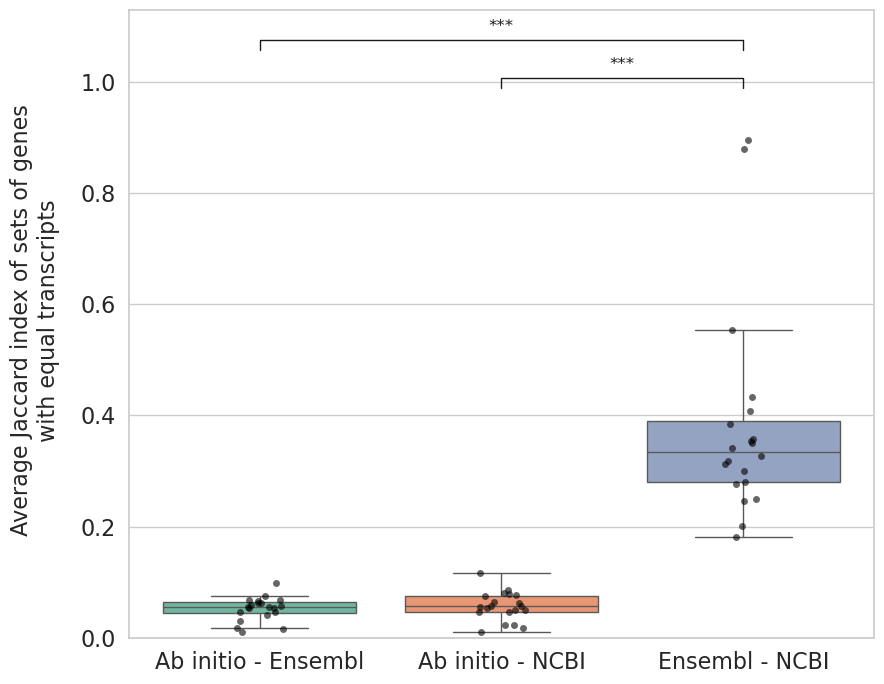

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the plot style
sns.set(style="whitegrid")

# Initialize the matplotlib figure
fig, ax= plt.subplots(figsize=(9,7))
fig = sns.boxplot(x="Method Pair", y="Jaccard Index",hue='Method Pair', data=subset_df, palette="Set2", showfliers=False)
# Create the boxplot


# Overlay stripplot with individual points
sns.stripplot(x="Method Pair", y="Jaccard Index", data=subset_df, color="black", size=5, jitter=True, alpha=0.6)

# Pre-calculated p-values for pairwise comparisons
p_values = {
    ('Ab initio - Ensembl', 'Ensembl - NCBI'): 0.000,  # Replace with your actual p-values
    ('Ab initio - NCBI', 'Ensembl - NCBI'): 0.000,
    # Add more pairs and their respective p-values here
}

# Set significance levels
alpha_levels = [0.05, 0.01, 0.001]

# Get the y-axis limits
bottom, top = ax.get_ylim()
y_range = top - bottom

# Significance bars
for i, ((method1, method2), p) in enumerate(p_values.items()):
    # Columns corresponding to the datasets of interest
    x1 = [j for j, method in enumerate(subset_df['Method Pair'].unique()) if method == method1][0]
    x2 = [j for j, method in enumerate(subset_df['Method Pair'].unique()) if method == method2][0]

    # What level is this bar among the bars above the plot?
    level = len(p_values) - i

    # Plot the bar
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )

    # Significance level
    sig_symbol = ''
    for alpha_level in alpha_levels:
        if p < alpha_level:
            if alpha_level == 0.001:
                sig_symbol = '***'
            elif alpha_level == 0.01:
                sig_symbol = '**'
            elif alpha_level == 0.05:
                sig_symbol = '*'

    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')

# Add labels and title
#plt.title("Jaccard Index per Method Pair Across Species")
#plt.xlabel("Method Pair", fontsize=16)
plt.ylim(0.00,)
plt.ylabel(" Average Jaccard index of sets of genes\n with equal transcripts", fontsize=16, labelpad=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# Optional: rotate x-axis labels if too crowded
plt.xlabel('')
# Show the plot
plt.tight_layout()
plt.savefig('Jaccard-gffcompare-genes.svg')


In [ ]:
# Annotate outliers for "Ensembl-NCBI"
for _, row in outliers.iterrows():
    x = list(avg_df["Method Pair"].unique()).index("Ensembl-NCBI")  # x-position of the Ensembl-NCBI box
    y = row["Jaccard Index"]
    species = row["Species"]
    plt.text(x, y, species, fontsize=8, rotation=30)


In [115]:
# Filter the relevant rows
subset = subset_df[subset_df["Method Pair"] == "Augustus-Ensembl"]

# Compute Q1, Q3, and IQR
q1 = subset["Jaccard Index"].quantile(0.25)
q3 = subset["Jaccard Index"].quantile(0.75)
iqr = q3 - q1

# Define outliers
outliers = subset[
    (subset["Jaccard Index"] < q1 - 0.15 * iqr) | 
    (subset["Jaccard Index"] > q3 + 0.15 * iqr)
]

In [116]:
outliers.sort_values(by='Jaccard Index')

,Species,Method Pair,Jaccard Index
25,Erpetoichthys calabaricus,Augustus-Ensembl,0.009903
115,Xenopus tropicalis,Augustus-Ensembl,0.016731
1,Chrysemys picta bellii,Augustus-Ensembl,0.017954
55,Lepisosteus oculatus,Augustus-Ensembl,0.030791
97,Sarcophilus harrisii,Augustus-Ensembl,0.041572
7,Ciona intestinalis,Augustus-Ensembl,0.068510
49,Homo sapiens,Augustus-Ensembl,0.068537
43,Gallus gallus,Augustus-Ensembl,0.074522
13,Danio rerio,Augustus-Ensembl,0.097775
